# Kaggle

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamrannaseer","key":"86bfee909777b6a9a32c48d76ca589d5"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

## Getting Data

In [6]:
!kaggle datasets download -d ozlerhakan/spam-or-not-spam-dataset

  0% 0.00/1.16M [00:00<?, ?B/s]
100% 1.16M/1.16M [00:00<00:00, 80.9MB/s]


In [7]:
!mkdir ozlerhakan

In [8]:
! unzip spam-or-not-spam-dataset.zip -d ozlerhakan

Archive:  spam-or-not-spam-dataset.zip
  inflating: ozlerhakan/spam_or_not_spam.csv  


# Data Analysis

## Import Libraries

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
import scipy
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [137]:
data = pd.read_csv("/content/ozlerhakan/spam_or_not_spam.csv")

In [138]:
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


### Email Text Working

In [139]:
data['email'][2966] = "this is over written"        # because this was creating error so i over write this record

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [140]:
all_mail_content = data["email"]

In [141]:
dont_include = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z",
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    "above", "across", "against", "along", "among", "around", "at", "before", "behind", "below", "beneath", "beside", "between", 
    "by", "down", "from", "in", "into", "near", "of", "off", "on", "to", "toward", "under", "upon", "with" , "within",
    "the","that","this","pc","have","has", "is", "will", "shall", "are", "am", "had", "did", "does", "did", "been",
    "~","`","!","@","#","$","%","^","&","*","(",")","_","-","+","=","{","}","[","]","|","\ ",",","?","/",">","<",".",":",";", " ",
    "0","1","2","3","4","5","6","7","8","9"
    ]
words_dict = {}
total_words = 0

In [142]:
# this code will create dictionary of words used in these emails
for each_mail in range(0, all_mail_content.shape[0]):
  each_mail_text = all_mail_content[each_mail]
  try:
    for word in each_mail_text.split(" "):
      if word in dont_include:
        print(end="")
      else:
        words_dict[word] = total_words
        total_words += 1
  except:
    print(each_mail,each_mail_text)

In [143]:
total_words

546033

In [144]:
words_dict

{'': 546032,
 'date': 534109,
 'wed': 530355,
 'NUMBER': 546016,
 'aug': 461403,
 'chris': 480550,
 'garrigues': 262762,
 'cwg': 260561,
 'dated': 481038,
 'NUMBERfaNUMBERd': 73448,
 'deepeddy': 260572,
 'com': 538870,
 'message': 540331,
 'id': 528267,
 'tmda': 338720,
 'vircio': 262764,
 'can': 545594,
 'reproduce': 397738,
 'error': 544931,
 'for': 545656,
 'me': 544978,
 'it': 545453,
 'very': 543815,
 'repeatable': 33,
 'like': 545042,
 'every': 545317,
 'time': 545658,
 'without': 544632,
 'fail': 541103,
 'debug': 410871,
 'log': 515922,
 'pick': 515123,
 'happening': 488799,
 'pick_it': 74341,
 'exec': 383287,
 'inbox': 448153,
 'list': 545248,
 'lbrace': 73559,
 'subject': 545103,
 'ftp': 536409,
 'rbrace': 73563,
 'sequence': 518989,
 'mercury': 381586,
 'ftoc_pickmsgs': 81,
 'hit': 529247,
 'marking': 409757,
 'hits': 523709,
 'tkerror': 93,
 'syntax': 399279,
 'expression': 311102,
 'int': 490521,
 'note': 543106,
 'if': 545223,
 'run': 540551,
 'command': 468944,
 'hand': 

In [145]:
# this code will remove the duplicate words
compressed_words_dictionary = {}
word_number = 0
for key,value in words_dict.items():
    if key not in compressed_words_dictionary.keys():
        compressed_words_dictionary[key] = word_number
        word_number += 1


In [146]:
len(compressed_words_dictionary)

34153

In [93]:
# print(compressed_words_dictionary)

In [164]:
# this code will create encoded emails with the help of dictionary created above
encoded_all_mails = []

for each_mail in range(0, all_mail_content.shape[0]):
  each_mail_text = all_mail_content[each_mail][:400]  # we will choose only first 400 words in mail
  current_mail_code = []
  try:
    for word in each_mail_text.split(" "):
      if word in compressed_words_dictionary.keys():
        required_number = compressed_words_dictionary[word]
        current_mail_code.append(required_number)
    encoded_all_mails.append(current_mail_code)
  except:
    print(each_mail,each_mail_text)


In [160]:
encoded_all_mails

[[0,
  1,
  2,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  5,
  6,
  7,
  8,
  3,
  9,
  10,
  11,
  12,
  13,
  3,
  3,
  14,
  10,
  15,
  11,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  3,
  3,
  3,
  33,
  34,
  31,
  35,
  36,
  37,
  37,
  38,
  39,
  40,
  40,
  3],
 [110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  3,
  121,
  122,
  123,
  68,
  124,
  125,
  119,
  126,
  127,
  128,
  129,
  130,
  19,
  131,
  132,
  133,
  134,
  133,
  135,
  136,
  137,
  3,
  138,
  139,
  68,
  3,
  138,
  140,
  141,
  142,
  143,
  68,
  144,
  145,
  19,
  146,
  147,
  148,
  149,
  19449],
 [171,
  172,
  173,
  174,
  175,
  176,
  3,
  3,
  3,
  3,
  177,
  174,
  178,
  179,
  180,
  175,
  181,
  166,
  182,
  171,
  183,
  184,
  185,
  129,
  186,
  187,
  68,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  179,
  196,
  197,
  174,
  198,
  199,
  200,
  180,
  181,
  166,
  201,
  20

In [156]:
# to know encoded maximum words any list has
max(map(len, encoded_all_mails))

95

In [165]:
# here i will decrease the length or increase the length of encoded mails to bring every encoded mail to equal size
for item in encoded_all_mails:              # for each item in the list
    while len(item) < max(map(len, encoded_all_mails)):                   # while the item length is smaller than  # -- max(map(len, encoded_all_mails))
        item.append(0)

In [166]:
# here we converted python list to numpy arrays
encoded_all_mails_array = np.array([np.array(each_mail_encoded) for each_mail_encoded in encoded_all_mails])

In [167]:
encoded_all_mails_array.shape

(3000, 95)

In [168]:
email_text_df = pd.DataFrame(encoded_all_mails_array)

In [169]:
email_text_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94
0,0,1,2,3,4,3,3,3,3,3,5,6,7,8,3,9,10,11,12,13,3,3,14,10,15,11,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,40,40,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,110,111,112,113,114,115,116,117,118,119,120,3,121,122,123,68,124,125,119,126,127,128,129,130,19,131,132,133,134,133,135,136,137,3,138,139,68,3,138,140,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,171,172,173,174,175,176,3,3,3,3,177,174,178,179,180,175,181,166,182,171,183,184,185,129,186,187,68,188,189,190,191,192,193,194,195,179,196,197,174,198,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,275,276,277,278,279,280,281,276,282,275,283,284,285,286,287,288,3,104,289,290,111,175,176,3,3,275,291,292,293,294,295,296,297,298,21,81,280,299,300,282,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,345,346,347,348,349,350,351,352,133,298,353,354,355,356,357,358,133,348,81,71,359,360,68,361,362,363,364,365,170,366,346,367,368,369,370,371,372,373,170,...,383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [170]:
all_mail_label = data["label"]

In [171]:
email_label_df = pd.DataFrame(all_mail_label)

In [172]:
email_label_df.head()

,label
0,0
1,0
2,0
3,0
4,0


In [221]:
main_data = email_text_df.join(email_label_df)

In [222]:
main_data.shape

(3000, 96)

In [223]:
main_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,label
0,0,1,2,3,4,3,3,3,3,3,5,6,7,8,3,9,10,11,12,13,3,3,14,10,15,11,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,40,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,110,111,112,113,114,115,116,117,118,119,120,3,121,122,123,68,124,125,119,126,127,128,129,130,19,131,132,133,134,133,135,136,137,3,138,139,68,3,138,140,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,171,172,173,174,175,176,3,3,3,3,177,174,178,179,180,175,181,166,182,171,183,184,185,129,186,187,68,188,189,190,191,192,193,194,195,179,196,197,174,198,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,275,276,277,278,279,280,281,276,282,275,283,284,285,286,287,288,3,104,289,290,111,175,176,3,3,275,291,292,293,294,295,296,297,298,21,81,280,299,300,282,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,345,346,347,348,349,350,351,352,133,298,353,354,355,356,357,358,133,348,81,71,359,360,68,361,362,363,364,365,170,366,346,367,368,369,370,371,372,373,170,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### ANN Modeling

In [224]:
y = main_data["label"]
X = main_data.drop(["label"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) # 0.25 x 0.8 = 0.2

In [232]:
# model definition
model = Sequential()
# model body

model.add(Dense(64, activation="relu", input_shape=(X.shape[1],)))
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu" ))
model.add(Dropout(0.5))

model.add(Dense(32, activation="relu" ))
model.add(Dropout(0.3))

model.add(Dense(32, activation="relu" ))
model.add(Dropout(0.3))

model.add(Dense(8, activation="relu" ))
# model.add(Dropout(0.2))

model.add(Dense(1, activation="sigmoid" ))

# Compiling the model
model.compile(optimizer="rmsprop", loss = 'binary_crossentropy', metrics=['accuracy'])

In [233]:
# model training
history = model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_val, y_val))

Epoch 1/50
57/57 [==============================] - 1s 8ms/step - loss: 267.7046 - accuracy: 0.6274 - val_loss: 16.2975 - val_accuracy: 0.8383
Epoch 2/50
57/57 [==============================] - 0s 2ms/step - loss: 54.6556 - accuracy: 0.7040 - val_loss: 5.9324 - val_accuracy: 0.8300
Epoch 3/50
57/57 [==============================] - 0s 2ms/step - loss: 23.1611 - accuracy: 0.7417 - val_loss: 0.6086 - val_accuracy: 0.8267
Epoch 4/50
57/57 [==============================] - 0s 2ms/step - loss: 9.0878 - accuracy: 0.7588 - val_loss: 0.7501 - val_accuracy: 0.4250
Epoch 5/50
57/57 [==============================] - 0s 2ms/step - loss: 4.0369 - accuracy: 0.7602 - val_loss: 0.5887 - val_accuracy: 0.8350
Epoch 6/50
57/57 [==============================] - 0s 2ms/step - loss: 3.5415 - accuracy: 0.8130 - val_loss: 0.5850 - val_accuracy: 0.8350
Epoch 7/50
57/57 [==============================] - 0s 2ms/step - loss: 2.0954 - accuracy: 0.8220 - val_loss: 0.5894 - val_accuracy: 0.8350
Epoch 8/50
57/5

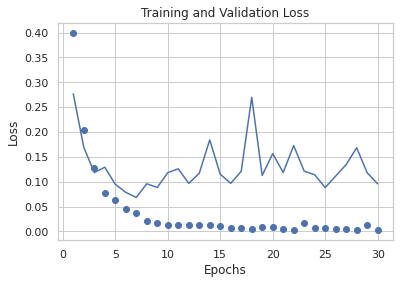

In [277]:

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Trainig Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [278]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Trainig Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

KeyError: ignored

In [230]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)

In [231]:
confusion_matrix(y_test, y_pred)

array([[487,   0],
       [113,   0]])

# Best Method

In [259]:
import pandas as pd
import numpy as np
data=pd.read_csv(r'/content/ozlerhakan/spam_or_not_spam.csv')
data.head()


,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [260]:
from sklearn.utils import shuffle
data = shuffle(data)

In [261]:
data['label'].value_counts()

0    2500
1     500
Name: label, dtype: int64

In [262]:
text =[] 
  
# Iterate over each row 
for index, rows in data.iterrows(): 
    # Create list for the current row 
    my_list = str(rows.email)
    # append the list to the final list 
    text.append(my_list) 
  
# Print the list 
len(text)

3000

In [269]:
label=np.array(list(data['label']))

In [270]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

In [271]:
x_train=sequences[:2000]
y_train=label[:2000]
x_test=sequences[2000:2500]
y_test=label[2000:2500]
x_val=sequences[2500:]
y_val=label[2500:]

In [272]:
maxlen = 30
from keras import preprocessing
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
x_val = preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)


In [282]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding,SimpleRNN
model = Sequential()
model.add(Embedding(2000, 8, input_length=maxlen))

model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val,y_val))

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 8)             16000     
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 33        
Total params: 17,345
Trainable params: 17,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
63/63 [==============================] - 1s 9ms/step - loss: 0.4910 - acc: 0.8024 - val_loss: 0.2846 - val_acc: 0.8980
Epoch 2/10
63/63 [==============================] - 0s 5ms/step - loss: 0.2488 - acc: 0.9162 - val_loss: 0.1549 - val_acc: 0.9580
Epoch 3/10
63/63 [==============================] - 0s 5ms/step - loss: 0.1280 - acc: 0.9643 - val_loss: 0.1884 - val_a

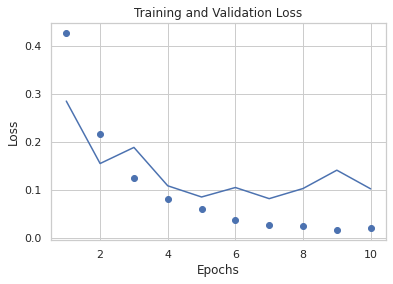

In [284]:

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Trainig Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

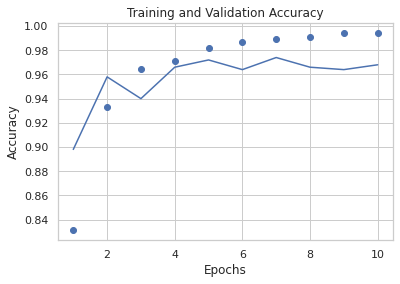

In [285]:
accuracy = history.history["acc"]
val_accuracy = history.history["val_acc"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Trainig Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [283]:
result=model.evaluate(x_test,y_test)
print("test loss:{}\ntest accuracy:{}".format(result[0],result[1]))

16/16 [==============================] - 0s 2ms/step - loss: 0.0949 - acc: 0.9700
test loss:0.09494286775588989
test accuracy:0.9700000286102295
